In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
!nvidia-smi

Thu Apr  8 15:16:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu


     |████████████████████████████████| 394.3MB 45kB/s 


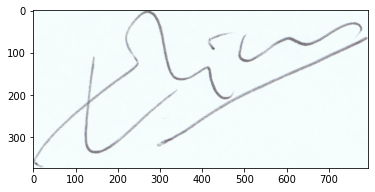

In [4]:
import matplotlib.pyplot as plt
img = plt.imread('/content/drive/MyDrive/dataset/input1/sign_data/train/001/001_04.PNG')
plt.imshow(img)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


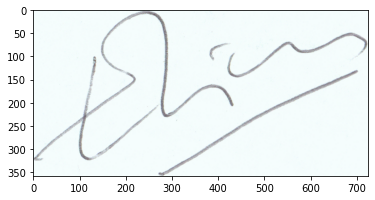

In [5]:
img1 = plt.imread('/content/drive/MyDrive/dataset/input1/sign_data/train/001/001_01.PNG')
plt.imshow(img1)

In [8]:
import os
import glob
import cv2
train_data = []
train_labels = []

for per in os.listdir('/content/drive/MyDrive/dataset/input1/sign_data/train'):
    for data in glob.glob('/content/drive/MyDrive/dataset/input1/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

In [9]:
test_data = []
test_labels = []

for per in os.listdir('/content/drive/MyDrive/dataset/input1/sign_data/test'):
    for data in glob.glob('/content/drive/MyDrive/dataset/input1/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)


In [10]:
from keras.utils import to_categorical
from sklearn.utils import shuffle
train_labels = to_categorical(train_labels)
train_data.shape

(1649, 1, 224, 224, 3)

In [11]:
train_data = train_data.reshape(-1, 224,224, 3)
test_data = test_data.reshape(-1, 224,224, 3)

In [30]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)
from keras import applications
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix as CM
from keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output)) # Add the last layer

model.compile(optimizer=Adam(lr=0.00001),loss="binary_crossentropy",metrics=["accuracy"])

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [31]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

callback_early_stop_reduceLROnPlateau=[earlyStopping]


EPOCHS = 5
BS = 1
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=callback_early_stop_reduceLROnPlateau,validation_split=.05)

Epoch 1/5
1566/1566 [==============================] - 49s 31ms/step - loss: 0.4207 - accuracy: 0.7579 - val_loss: 0.1354 - val_accuracy: 0.9277
Epoch 2/5
1566/1566 [==============================] - 49s 31ms/step - loss: 0.0859 - accuracy: 0.9717 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 3/5
1566/1566 [==============================] - 50s 32ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.1175 - val_accuracy: 0.9759
Epoch 4/5
1566/1566 [==============================] - 50s 32ms/step - loss: 0.0483 - accuracy: 0.9821 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/5
1566/1566 [==============================] - 51s 32ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2045e-04 - val_accuracy: 1.0000


In [32]:
predictions=model.predict(test_data)
pred=predictions.argmax(axis=1)

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
print(classification_report(test_labels,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       248

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [36]:
print(confusion_matrix(test_labels,pred))

[[252   0]
 [  0 248]]
